# **Health Insurance Cross Sell Prediction**

####**Introduction**

An insurance company, specializes in health insurance and is looking to expand its offerings by introducing vehicle insurance. To optimize their marketing efforts, they need insights into the interest of existing health insurance policyholders in vehicle insurance.

####**Goal**

The project's goal is to develop a predictive model that identifies health insurance policyholders from the past year who are likely to be interested in purchasing vehicle insurance. This model will enable the company to enhance customer engagement and effectively convert existing customers into vehicle insurance policyholders.

####**Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

####**Exploratory Data Analysis**

**The dataset**

In [ ]:
df_train = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')
df_train.shape, df_test.shape

((381109, 11), (127037, 10))

In [ ]:
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


**Visualize the data**

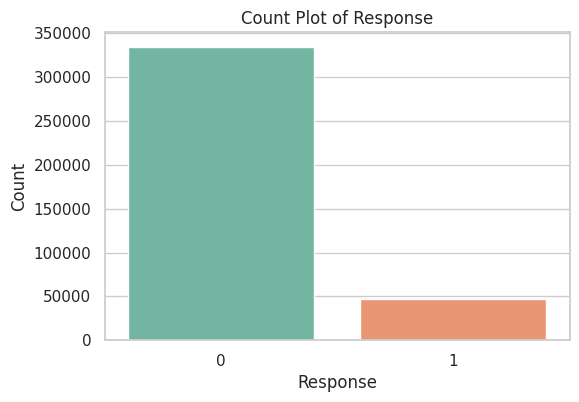

In [ ]:
# Create plot for target feature
plt.figure(figsize=(6, 4))
sns.countplot(x='Response', hue='Response', data=df_train, palette='Set2', legend=False)
plt.title('Count Plot of Response')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

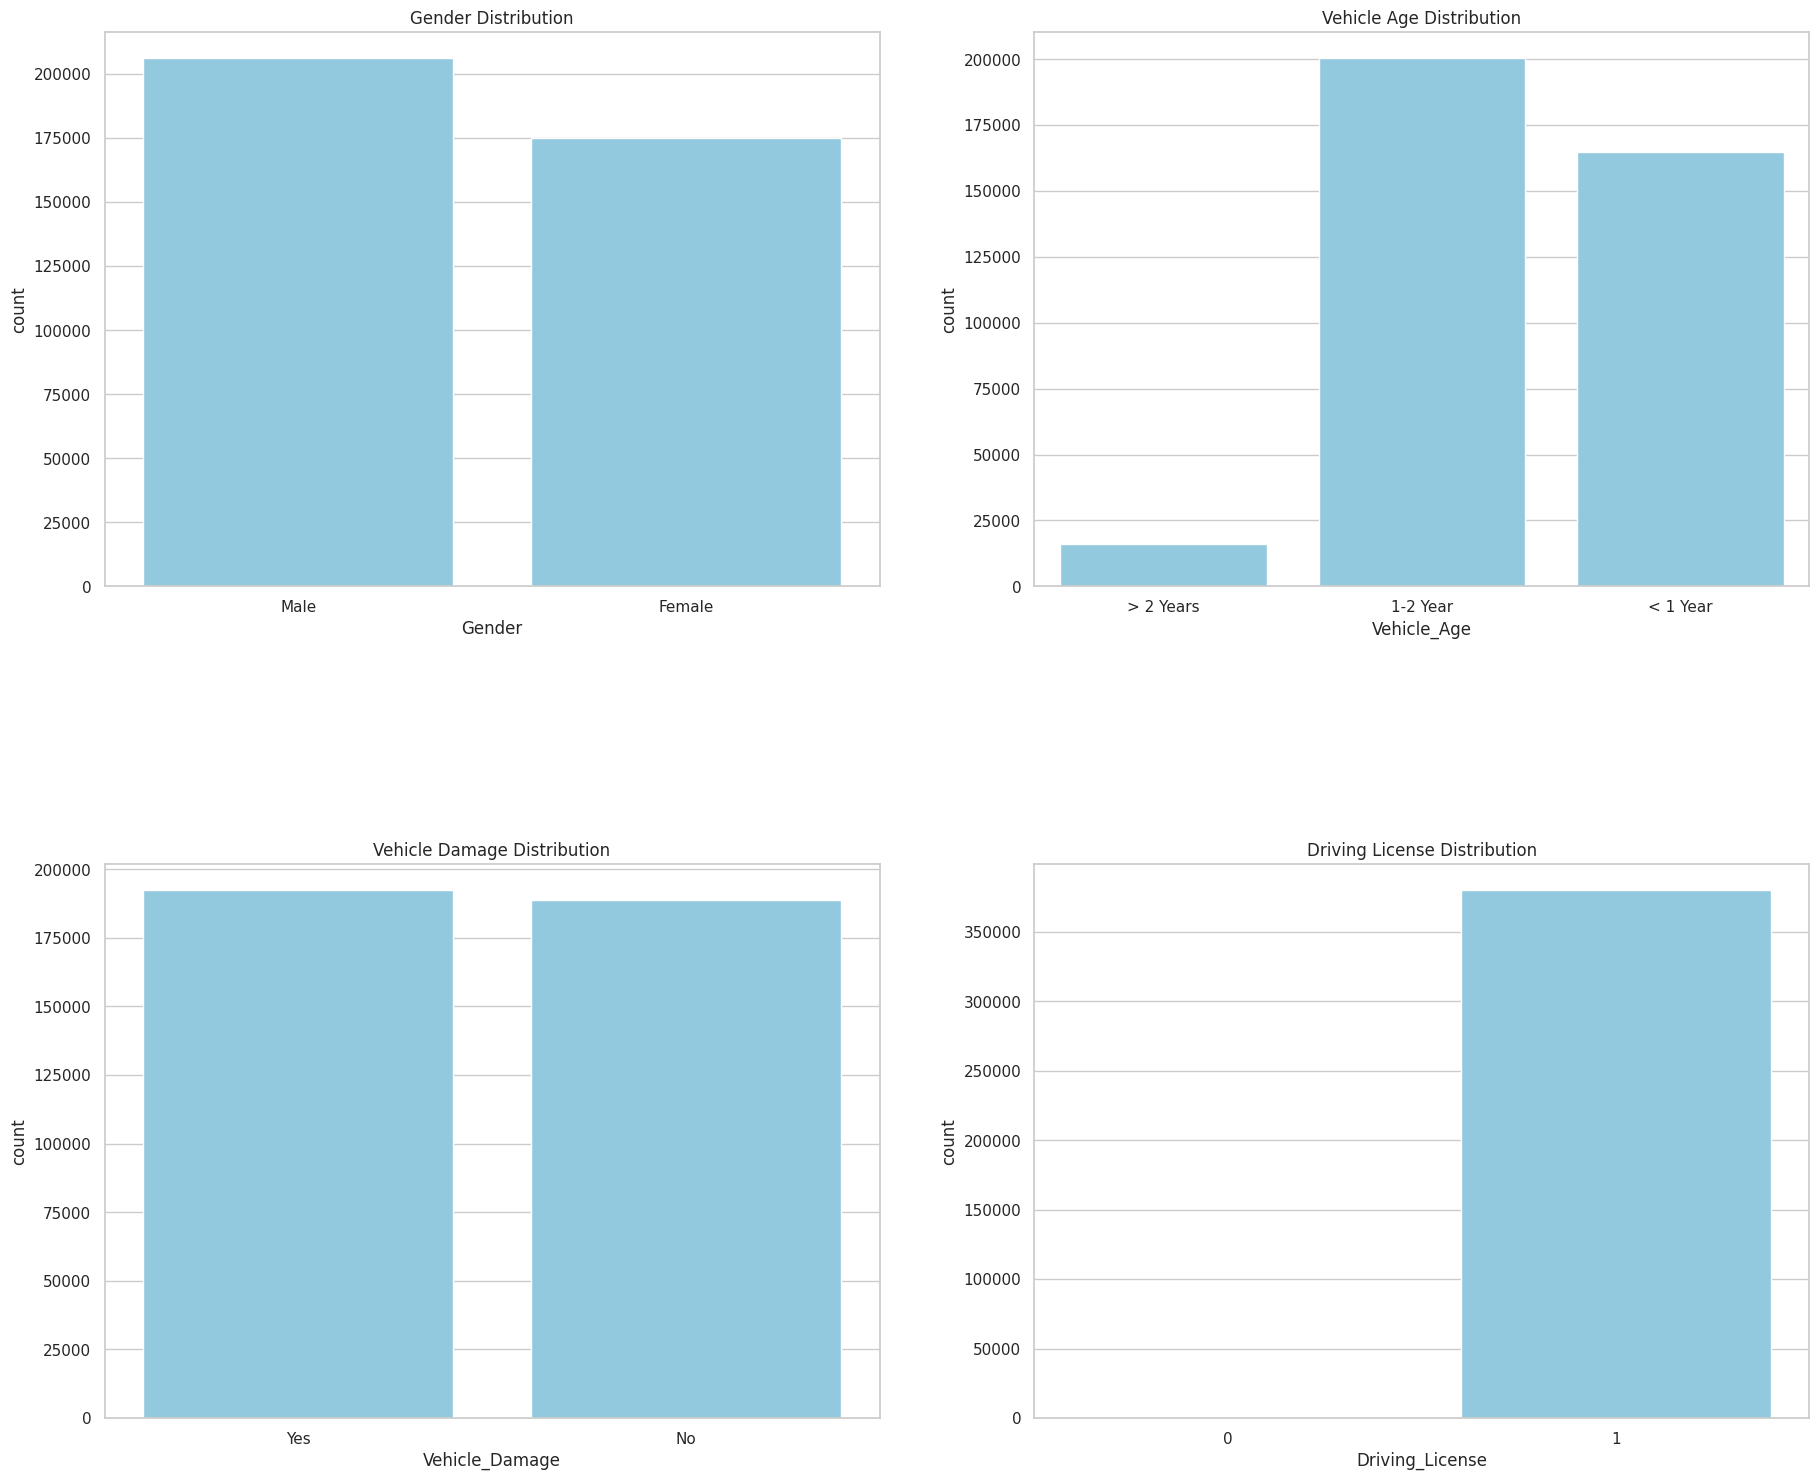

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots for the features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 18))
fig.subplots_adjust(hspace=0.5)

# Plot for 'Gender'
sns.countplot(x='Gender', data=df_train, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution')

# Plot for 'Vehicle_Age'
sns.countplot(x='Vehicle_Age', data=df_train, color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('Vehicle Age Distribution')

# Plot for 'Vehicle_Damage'
sns.countplot(x='Vehicle_Damage', data=df_train, color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('Vehicle Damage Distribution')

# Plot for 'Driving_License'
sns.countplot(x='Driving_License', data=df_train, color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('Driving License Distribution')

plt.show()

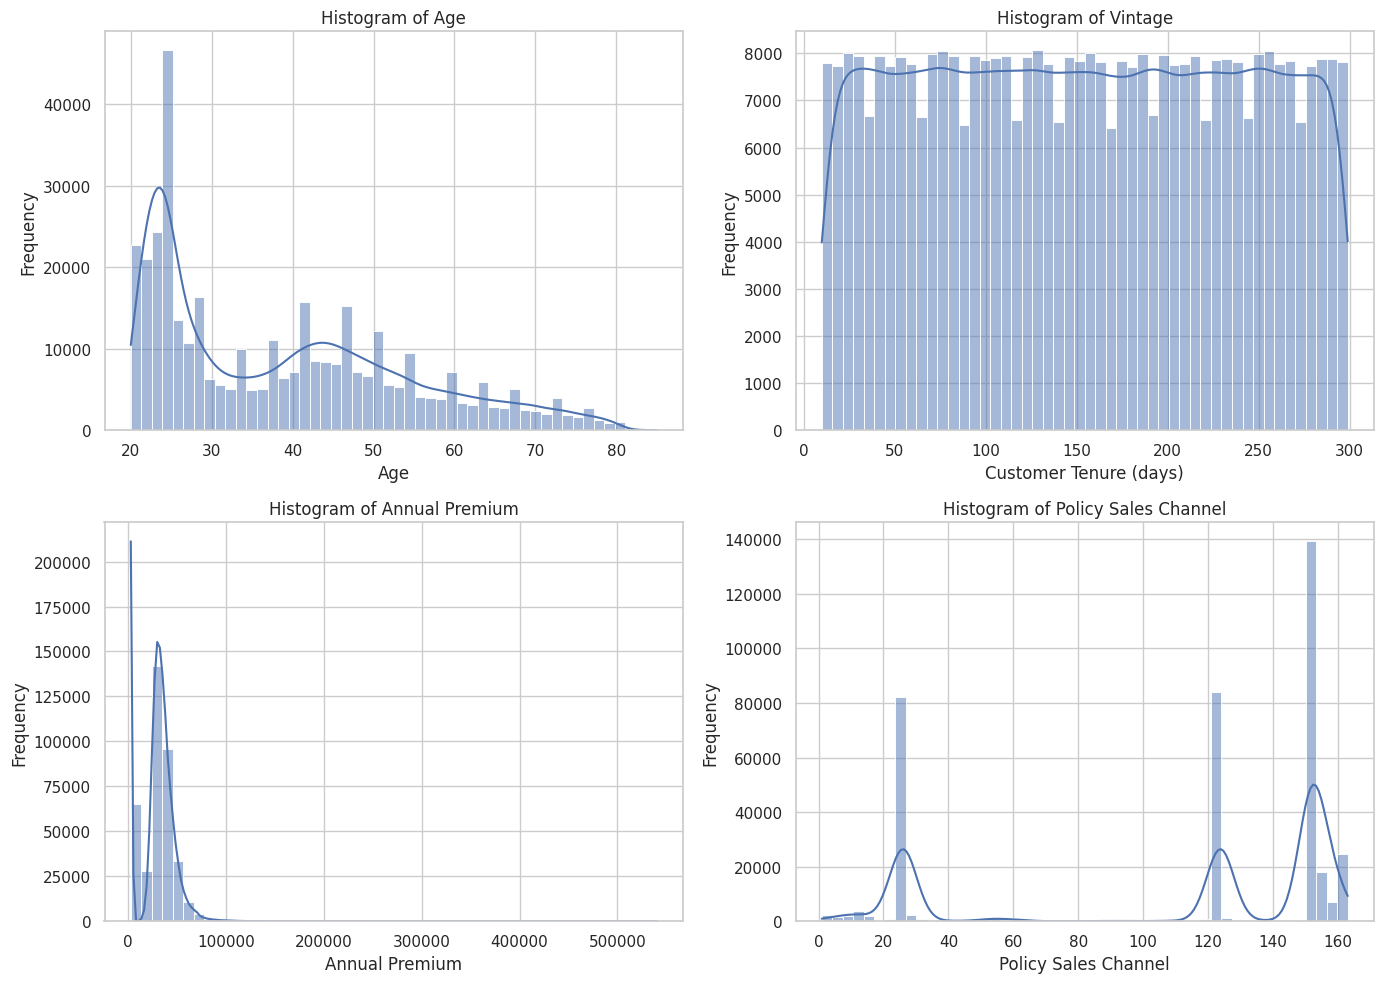

In [ ]:
# Set up the plotting area
plt.figure(figsize=(14, 10))

# Histogram for Age
plt.subplot(2, 2, 1)
sns.histplot(df_train['Age'], bins=50, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram for CustomerTenure
plt.subplot(2, 2, 2)
sns.histplot(df_train['Vintage'], bins=50, kde=True)
plt.title('Histogram of Vintage')
plt.xlabel('Customer Tenure (days)')
plt.ylabel('Frequency')

# Histogram for Annual Premium
plt.subplot(2, 2, 3)
sns.histplot(df_train['Annual_Premium'], bins=50, kde=True)
plt.title('Histogram of Annual Premium')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')

# Histogram for PolicySalesChannel
plt.subplot(2, 2, 4)
sns.histplot(df_train['Policy_Sales_Channel'], bins=50, kde=True)
plt.title('Histogram of Policy Sales Channel')
plt.xlabel('Policy Sales Channel')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

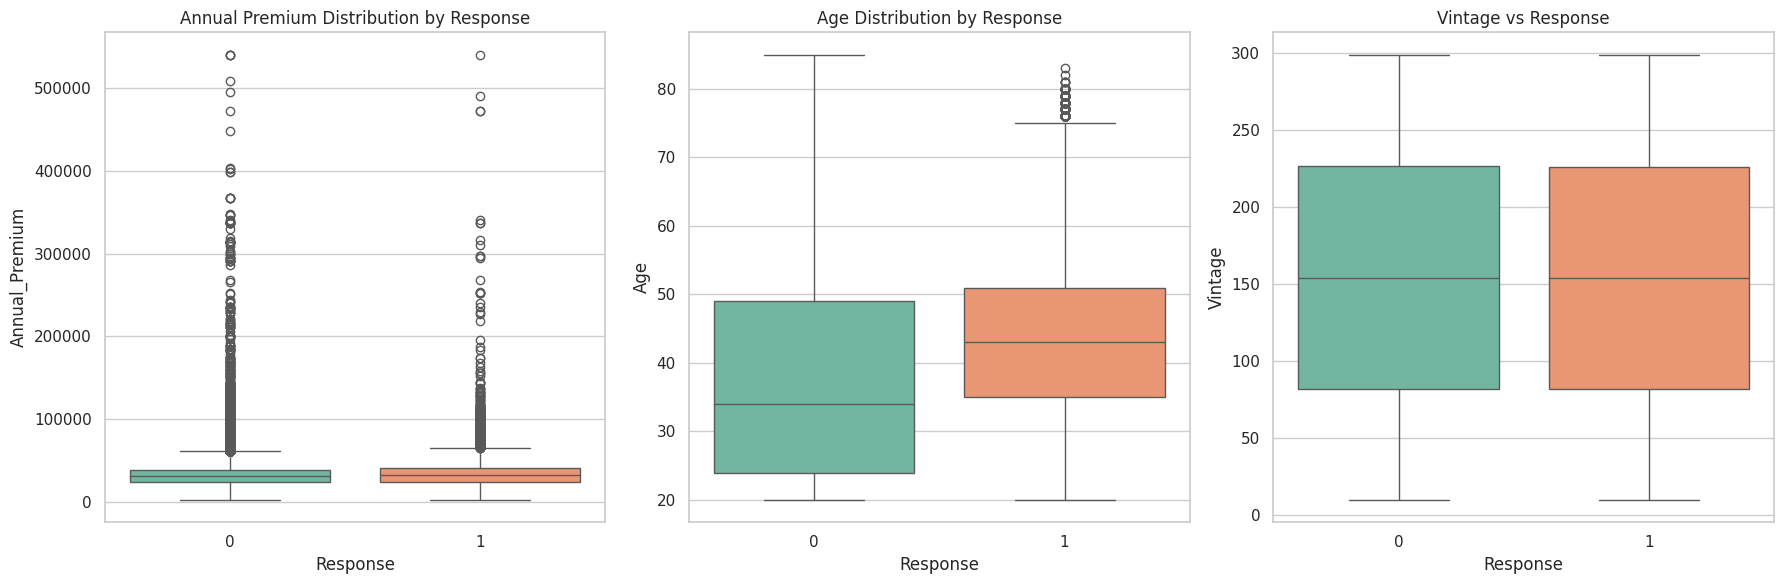

In [ ]:
# Create plots to check outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot of Annual_Premium vs. Response
sns.boxplot(x='Response', y='Annual_Premium', data=df_train, hue='Response', palette='Set2', dodge=False, ax=axes[0])
axes[0].set_title('Annual Premium Distribution by Response')
axes[0].legend([],[], frameon=False)

# Boxplot of Age vs. Response
sns.boxplot(x='Response', y='Age', data=df_train, hue='Response', palette='Set2', dodge=False, ax=axes[1])
axes[1].set_title('Age Distribution by Response')
axes[1].legend([],[], frameon=False)

# Box plot for 'Vintage' vs 'Response'
sns.boxplot(x='Response', y='Vintage', data=df_train, hue='Response', palette='Set2', dodge=False, ax=axes[2]) #Using hue and dodge
axes[2].set_title('Vintage vs Response')
axes[2].legend([],[], frameon=False)


plt.tight_layout()
plt.show()

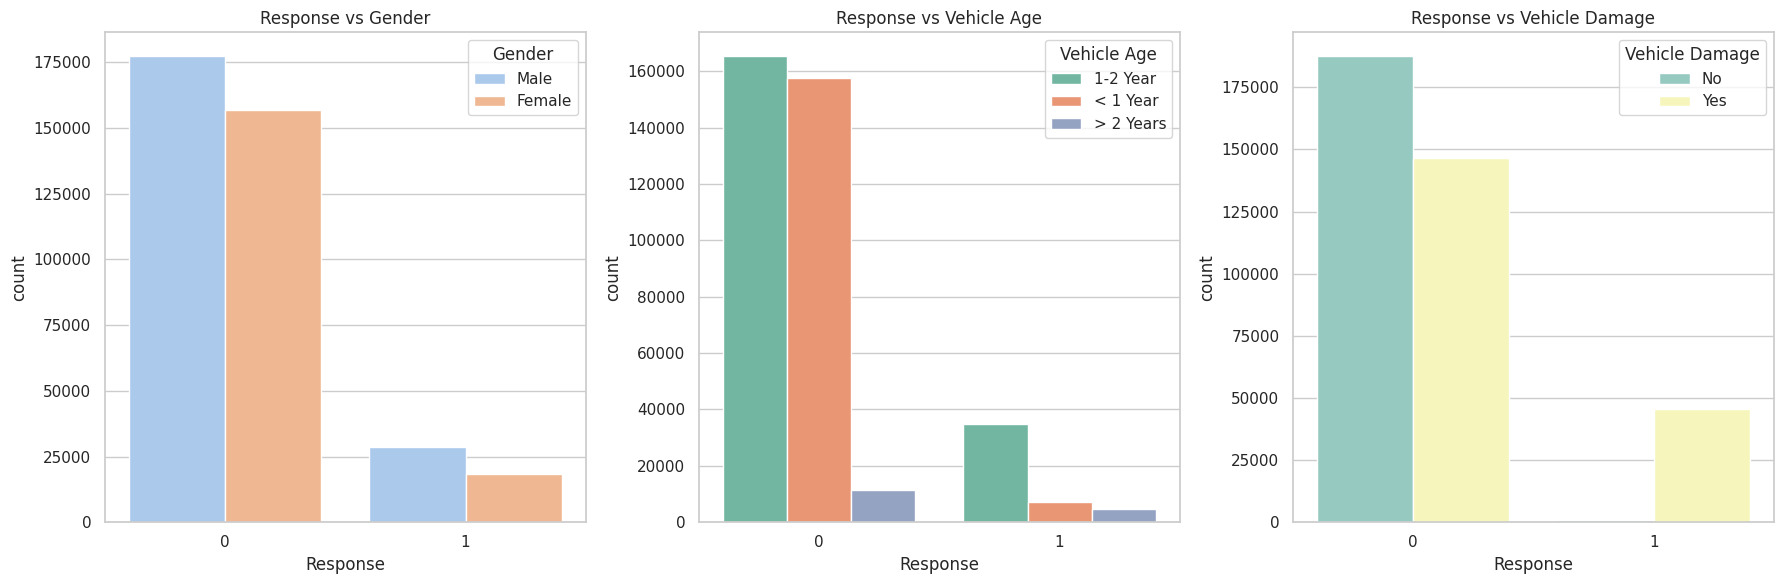

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Countplot for Gender vs. Response
sns.countplot(x='Response', hue='Gender', data=df_train, palette='pastel', ax=axes[0])
axes[0].set_title('Response vs Gender')
axes[0].legend(title='Gender', loc='upper right')

# Countplot for Vehicle_Age vs. Response
sns.countplot(x='Response', hue='Vehicle_Age', data=df_train, palette='Set2', ax=axes[1])
axes[1].set_title('Response vs Vehicle Age')
axes[1].legend(title='Vehicle Age', loc='upper right')

# Countplot for Vehicle_Damage vs. Response
sns.countplot(x='Response', hue='Vehicle_Damage', data=df_train, palette='Set3', ax=axes[2])
axes[2].set_title('Response vs Vehicle Damage')
axes[2].legend(title='Vehicle Damage', loc='upper right')

plt.tight_layout()
plt.show()

**Understand the data**

In [ ]:
df_test['Response'] = -1  # Add 'Response' column with placeholder value
combined_df = pd.concat([df_train, df_test], axis=0)
combined_df.shape

(508146, 11)

In [ ]:
combined_df.duplicated().sum(); combined_df.drop_duplicates(inplace=True)

In [ ]:
combined_df.isna().sum()

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507840 entries, 1 to 508146
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                507840 non-null  object 
 1   Age                   507840 non-null  int64  
 2   Driving_License       507840 non-null  int64  
 3   Region_Code           507840 non-null  float64
 4   Previously_Insured    507840 non-null  int64  
 5   Vehicle_Age           507840 non-null  object 
 6   Vehicle_Damage        507840 non-null  object 
 7   Annual_Premium        507840 non-null  float64
 8   Policy_Sales_Channel  507840 non-null  float64
 9   Vintage               507840 non-null  int64  
 10  Response              507840 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 46.5+ MB


In [ ]:
combined_df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000
mean,38.809121,0.997934,26.406329,0.458678,30571.116527,111.973251,154.337187,-0.158150
std,15.501547,0.045402,13.225106,0.498290,17138.098052,54.247523,83.668423,0.563024
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,-1.000000
25%,25.000000,1.000000,15.000000,0.000000,24403.000000,26.000000,82.000000,-1.000000
50%,36.000000,1.000000,28.000000,0.000000,31670.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39409.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [ ]:
combined_df.describe(include='object')

,Gender,Vehicle_Age,Vehicle_Damage
count,507840,507840,507840
unique,2,3,2
top,Male,1-2 Year,Yes
freq,274151,266843,256086


- Observations:
1. The data has no missing values
2. The duplicate rows have been dropped
3. The Age and Annual Premium features contain outliers, however, there is no need to treat the outliers in Age as it does no affect the analysis as much as Annual Premium.

####**Data Preprocessing**

**Feature engineering**
- Treat outliers in Annual Premium
- Create new features

In [ ]:
# Calculate the thresholds for capping and cap outliers in the original column
lower_threshold = combined_df['Annual_Premium'].quantile(0.05)  # 5th percentile
upper_threshold = combined_df['Annual_Premium'].quantile(0.95)  # 95th percentile
combined_df['Annual_Premium'] = combined_df['Annual_Premium'].clip(lower=lower_threshold, upper=upper_threshold)

In [ ]:
# Create new feature Vehicle_Category
def label_vehicle_category(row):
    if row['Vehicle_Age'] == '< 1 Year':
        return 'New-Damaged' if row['Vehicle_Damage'] == 'Yes' else 'New-Undamaged'
    elif row['Vehicle_Age'] == '> 2 Years':
        return 'Old-Damaged' if row['Vehicle_Damage'] == 'Yes' else 'Old-Undamaged'
    else:
        return 'Mid-Damaged' if row['Vehicle_Damage'] == 'Yes' else 'Mid-Undamaged'

combined_df['Vehicle_Category'] = combined_df.apply(label_vehicle_category, axis=1)

In [ ]:
# Create new feature Age_Vehicle_Damage
def create_age_vehicle_damage_category(row):
    age_group = 'Young' if row['Age'] < 30 else 'Middle-Aged' if row['Age'] < 50 else 'Senior'
    return f"{age_group} - {'Damaged' if row['Vehicle_Damage'] == 'Yes' else 'Undamaged'}"

combined_df['Age_Vehicle_Damage'] = combined_df.apply(create_age_vehicle_damage_category, axis=1)

In [ ]:
# Create new feature Vehicle_Age_Risk
def create_vehicle_age_insurance_risk(row):
    if row['Vehicle_Age'] == '< 1 Year':
        return 'Low Risk' if row['Previously_Insured'] == 'Yes' else 'Medium Risk'
    elif row['Vehicle_Age'] == '1-2 Years':
        return 'Medium Risk'
    else:
        return 'High Risk' if row['Previously_Insured'] == 'No' else 'Medium Risk'

combined_df['Vehicle_Age_Risk'] = combined_df.apply(create_vehicle_age_insurance_risk, axis=1)

In [ ]:
# Create new feature Premium_Risk
def create_premium_risk_category(row):
    if row['Vehicle_Damage'] == 'Yes':
        return 'High Risk' if row['Annual_Premium'] > 2000 else 'Medium Risk'
    else:
        return 'Low Risk'

combined_df['Premium_Risk'] = combined_df.apply(create_premium_risk_category, axis=1)

In [ ]:
combined_df.head(10)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Category,Age_Vehicle_Damage,Vehicle_Age_Risk,Premium_Risk
id,,,,,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,Old-Damaged,Middle-Aged - Damaged,Medium Risk,High Risk
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,Mid-Undamaged,Senior - Undamaged,Medium Risk,Low Risk
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,Old-Damaged,Middle-Aged - Damaged,Medium Risk,High Risk
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,New-Undamaged,Young - Undamaged,Medium Risk,Low Risk
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,New-Undamaged,Young - Undamaged,Medium Risk,Low Risk
6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0,New-Damaged,Young - Damaged,Medium Risk,High Risk
7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0,New-Damaged,Young - Damaged,Medium Risk,High Risk
8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1,Mid-Damaged,Senior - Damaged,Medium Risk,High Risk
9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0,New-Undamaged,Young - Undamaged,Medium Risk,Low Risk


In [ ]:
combined_df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000,507840.000000
mean,38.809121,0.997934,26.406329,0.458678,29911.217129,111.973251,154.337187,-0.158150
std,15.501547,0.045402,13.225106,0.498290,15008.123097,54.247523,83.668423,0.563024
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,-1.000000
25%,25.000000,1.000000,15.000000,0.000000,24403.000000,26.000000,82.000000,-1.000000
50%,36.000000,1.000000,28.000000,0.000000,31670.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39409.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,55197.050000,163.000000,299.000000,1.000000


- Split the combined dataframe back to their original

In [ ]:
df_train = combined_df[combined_df['Response'] != -1]
df_test = combined_df[combined_df['Response'] == -1]
df_test = df_test.drop(columns=['Response'])
df_train.shape, df_test.shape

((380840, 15), (127000, 14))

**Split the data into training and test set for df_train**

In [ ]:
# seperate target column from the features
X= df_train.drop(columns=["Response"], axis=1)
y= df_train["Response"]

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

**Feature scaling and encoding**

In [ ]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor on the training data and transform both training and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
df_test_processed = preprocessor.transform(df_test)

In [ ]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print(Counter(y_train))
print(Counter(y_train_balanced))

Counter({0: 267324, 1: 37348})
Counter({0: 267324, 1: 267324})


####**Model selection and training**

In [ ]:
# Create a random sample from the original training dataset
X_sample, y_sample = resample(X_train_balanced, y_train_balanced, n_samples=10000, random_state=42)

- Using stratifiedKFold cross-validation to identify the best model with highest ROC-AUC score.

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost Classifier': XGBClassifier(eval_metric='logloss', random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='roc_auc')
    model_results[model_name] = {
        'Mean ROC-AUC': cv_scores.mean()
    }
for model_name, metrics in model_results.items():
    print(f"{model_name}: Mean ROC-AUC | {metrics['Mean ROC-AUC']:.4f}")

Logistic Regression: Mean ROC-AUC | 0.8472
Random Forest: Mean ROC-AUC | 0.8918
Support Vector Classifier: Mean ROC-AUC | 0.8419
Decision Tree: Mean ROC-AUC | 0.8036
XGBoost Classifier: Mean ROC-AUC | 0.9260


- Fine-tuning the best model to identify the optimal parameters for XGBoost classifer.

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search= RandomizedSearchCV(estimator=XGBClassifier( eval_metric='logloss', random_state=42),
    param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search.fit(X_train_balanced, y_train_balanced)
best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
print("Best ROC-AUC Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best ROC-AUC Score: 0.9574735413038713


####**Model Evaluation**

- fit the best model on the entire training set

In [ ]:
best_model.fit(X_train_balanced, y_train_balanced)

y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]

**Metrics**

- The ROC (Receiver Operating Characteristic) curve is a graphical representation of a classifier's performance across different thresholds. The area under the curve (AUC) quantifies the overall ability of the model to discriminate between the positive and negative classes.

In [ ]:
roc_auc_score(y_test, y_pred_proba)

0.8391675895697656

ROC AUC Score: 0.8392


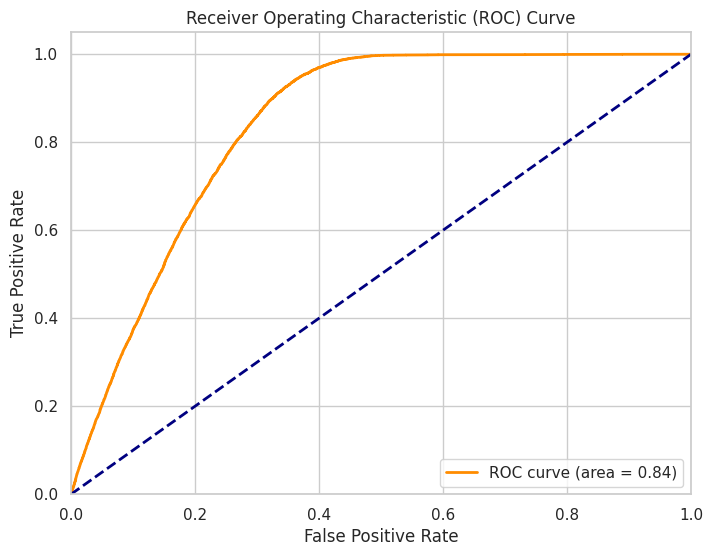

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Classification report computes and returns a text summary of various classification metrics for each class.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     66831
           1       0.33      0.51      0.40      9337

    accuracy                           0.81     76168
   macro avg       0.63      0.68      0.64     76168
weighted avg       0.85      0.81      0.83     76168



- Confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions.

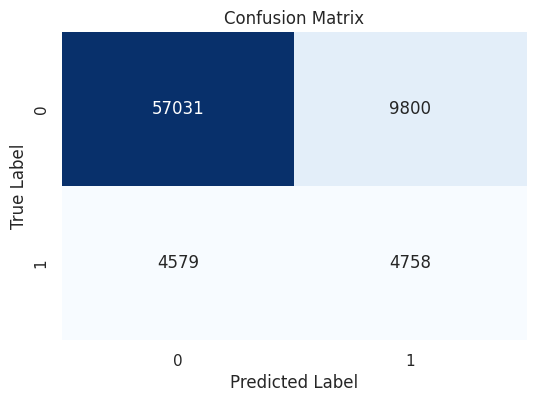

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Submission data**

In [ ]:
predictions_proba = best_model.predict_proba(df_test_processed)[:, 1]
predictions = best_model.predict(df_test_processed)

submission = pd.DataFrame({
    'id': df_test.index,
    'Response': predictions,
    'Predicted Probability': predictions_proba})

submission.to_csv('submission.csv', index=False)

print(submission.head())

       id  Response  Predicted Probability
0  381110         0               0.000947
1  381111         1               0.509273
2  381112         0               0.442991
3  381113         0               0.025819
4  381114         0               0.001128


####**Conclusion**

- The XGBoost classifier proved to be the best model for predicting customer interest in vehicle insurance, with an ROC AUC score of 0.8392. This indicates a strong capability to differentiate between interested and uninterested customers.

- Key Points from the Classification Report:

1. For Class 0 (Not Interested), the model effectively minimizes false positives with high precision (0.93), recall (0.85), and F1-score (0.89), focusing resources on likely leads.

2. For Class 1 (Interested), performance is lower (precision 0.33, recall 0.51), indicating room for improvement, likely due to class imbalance.

- In summary, while the model achieves strong overall accuracy (0.81) and general performance, future work could target recall improvements for interested customers by exploring sampling strategies or additional tuning, aiming for more balanced predictions across classes.

- In addition, I plan to perform a clustering analysis for customer segmentation. This will provide deeper insights into distinct customer groups, enabling more targeted strategies for engaging potential vehicle insurance customers.

- References

https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics